# Progress Task 1: Prediction of wine quality

## Introduction

This progress task has the aim to predict the quality of wine based on its physicochemical properties. The dataset used in this task is the [Wine Quality Dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) from the UCI Machine Learning Repository. Credits to *P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.*

The objective of this task is to select an apropiate regression and classification model and compare them.

## Prepare environmental variables

Download the dataset and import the necessary packages.

In [ ]:
%pip install ucimlrepo seaborn matplotlib scikit-learn pandas numpy pygam

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
from ucimlrepo import fetch_ucirepo 
 
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
 
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 

df_wine = pd.concat([X,y], axis=1)
 
# metadata 
print(wine_quality.metadata) 

# get variable information 
print(wine_quality.variables)

## Exploratory Data Analysis (EDA)

In this section, a brief exploratory data analysis (EDA) will be performed on the dataset, prior to correctly pre-process it and capture the most relevant features for model training.

### Describing the dataset

In [ ]:
# Check the number of instances and the number of features
print ("Shape of data:", X.shape , y.shape)

In [5]:
# Print the first rows of the features
print("=================== Feature's First Rows ===================\n", X.head(3), "\n")

# Print the first rows of the target
print("=================== Target's First Rows ===================\n", y.head(3), "\n")

=================== Feature's First Rows ===================
    fixed_acidity  volatile_acidity  citric_acid  ...    pH  sulphates  alcohol
0            7.4              0.70         0.00  ...  3.51       0.56      9.4
1            7.8              0.88         0.00  ...  3.20       0.68      9.8
2            7.8              0.76         0.04  ...  3.26       0.65      9.8

[3 rows x 11 columns] 

=================== Target's First Rows ===================
    quality
0        5
1        5
2        5 



In [ ]:
# Check for missing values
print("=================== Null value count ===================\n",df_wine.isnull().sum(), "\n")

In [22]:
df_wine.describe(percentiles=[])

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Now that we have taken a look into the dataset, here's a summary:

The dataset consists of 11 continuous features, none of them with missing values. The features are: 

* `fixed_acidity`: with values ranging from 4.6 to 15.9.
* `volatile_acidity`: with values ranging from 0.12 to 1.58.
* `citric_acid`: with values ranging from 0 to 1.66.
* `residual_sugar`: with values ranging from 0.6 to 65.8.
* `chlorides`: with values ranging from 0.009 to 0.611.
* `free_sulfur_dioxide`: with values ranging from 1 to 289.
* `total_sulfur_dioxide`: with values ranging from 6 to 440.
* `density`: with values ranging from 0.99 to 1.003.
* `pH`: with values ranging from 2.74 to 4.01.
* `sulphates`: with values ranging from 0.33 to 2.
* `alcohol`: with values ranging from 8.4 to 14.9.

The target variable is:
* `quality`: is an integer variable, from 0 to 10 but in this dataset it ranges from 3 to 9.

Now that the statistical summary of the dataset has been obtained, a pairplot will be created to visualize the relationships between the features and the target variable.

### Descriptive statistics

In [ ]:
sns.countplot(x='quality', data=df_wine)
plt.title("Distribution of Wine Quality Ratings")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

As shown in the plot, the target variable `quality` is not a balanced set. The majority of the wines have a quality of 5 or 6, with a few wines having a quality of 3 or 9. 

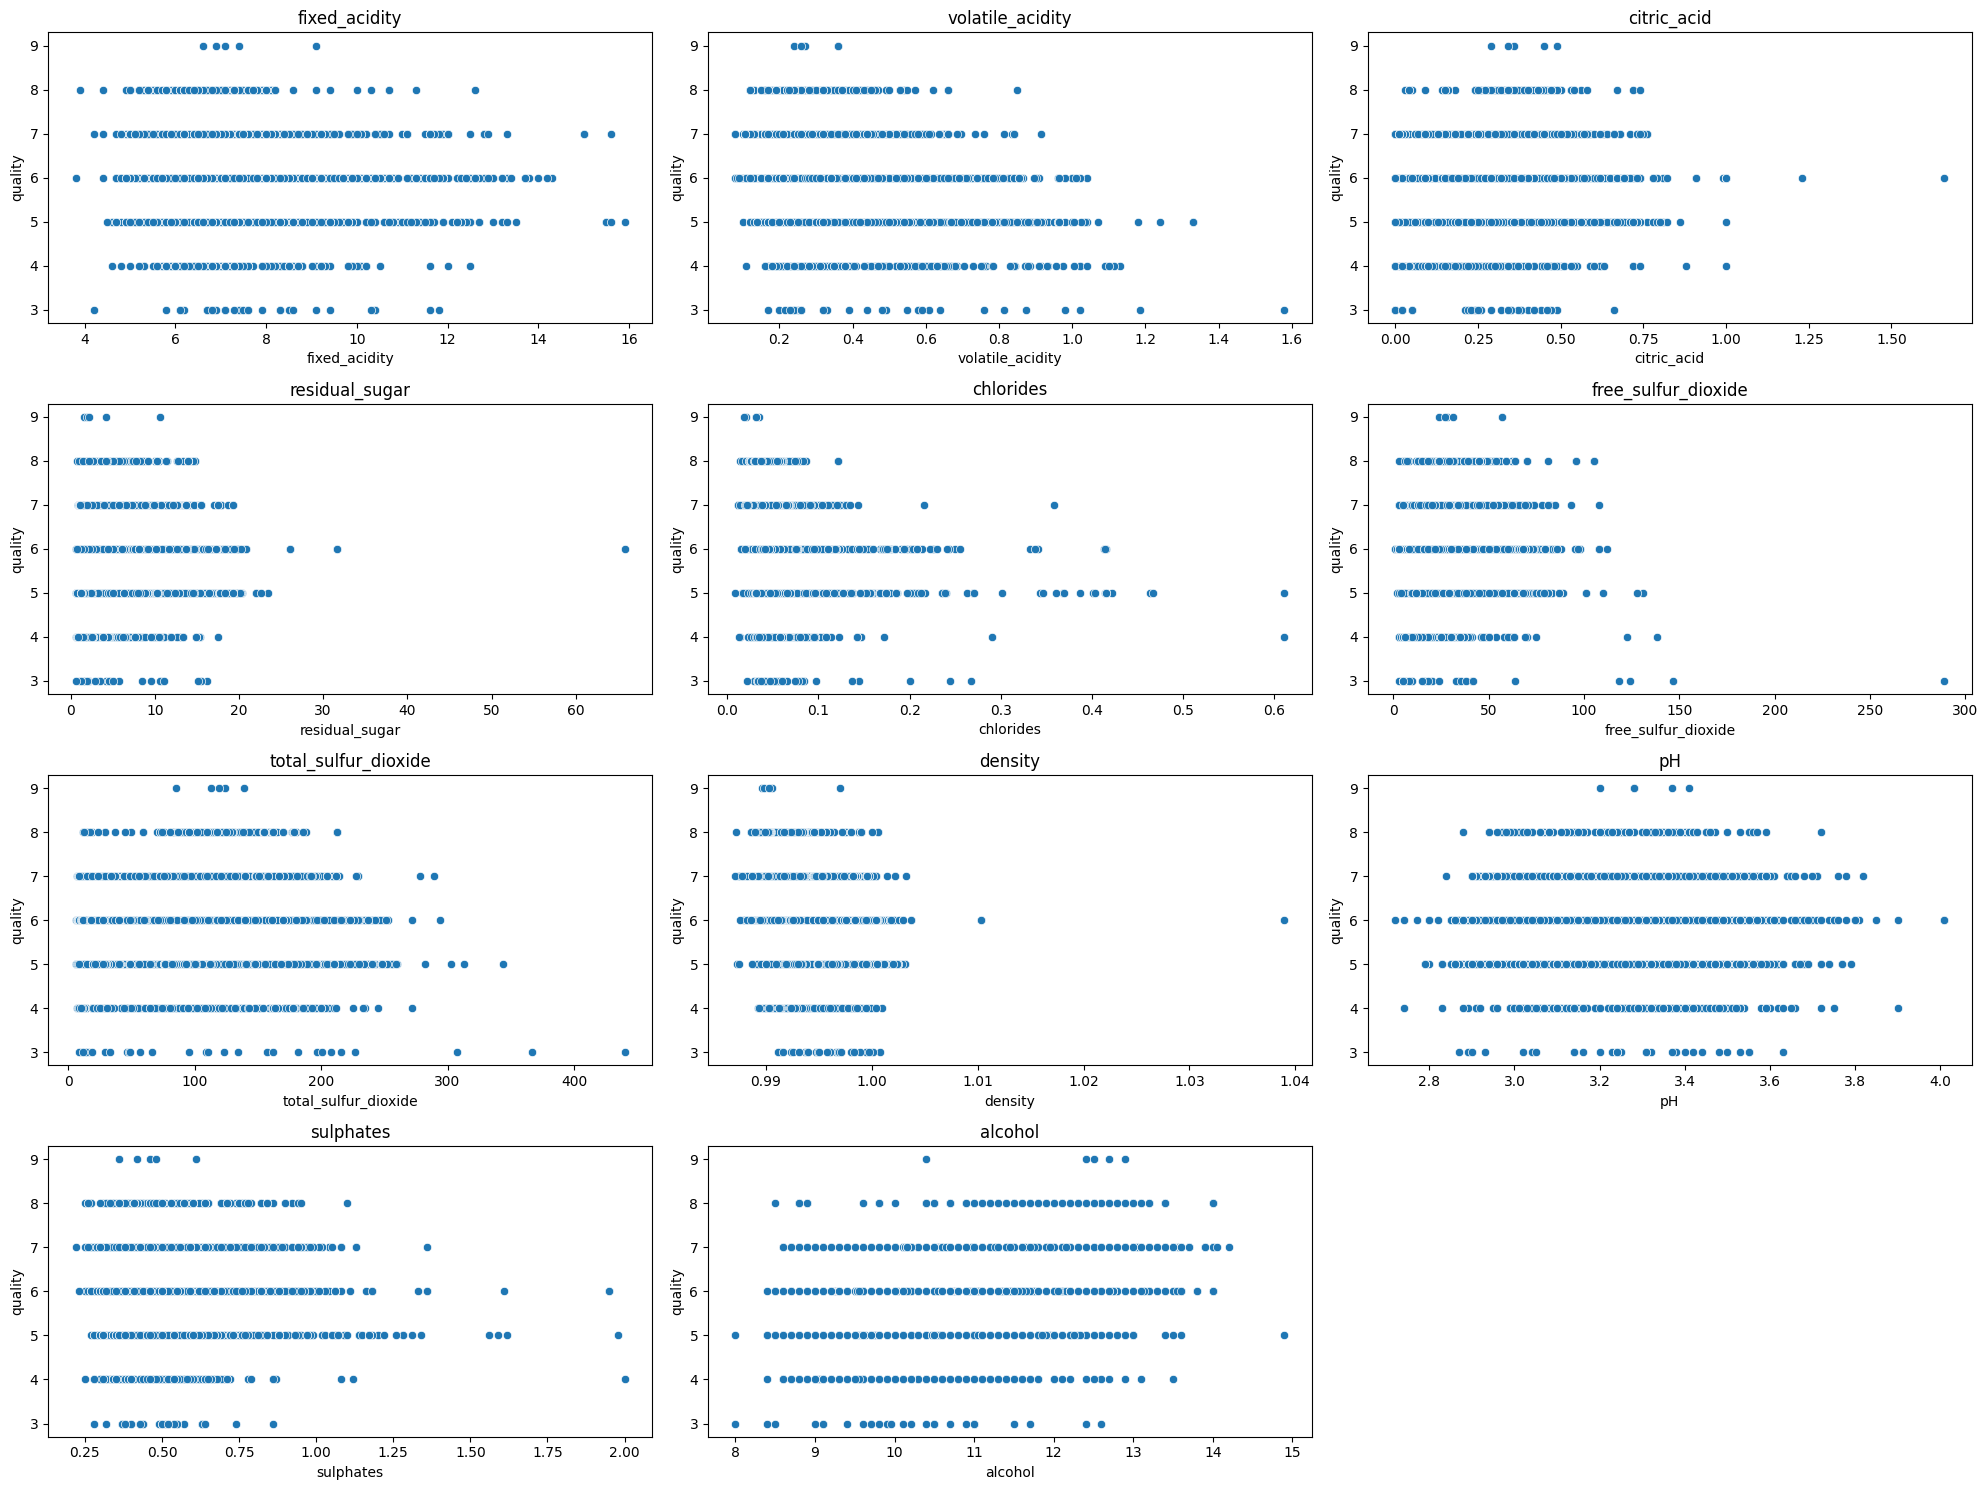

In [ ]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(df_wine.columns[:-1]):
    plt.subplot(4, 3, i + 1)
    sns.scatterplot(x=feature, y='quality', data=df_wine)
    plt.title(feature)
plt.tight_layout()
plt.show()

From the pairplot, a strange data distribution can be observed. All the instances seem to be grouped by a certain value of the variable `quality`. The reason for this is that the target variable is **discrete**, so **it is treated as a categorical variable**.

Given that no direct relation with the target can be inferred from the pairplot, the next step is to create pairplots between every pair of features. Then, the dependencies between the features will be analyzed.

In [ ]:
sns.pairplot(data = X)
plt.show()

From the pairplot there are some interesting observations: 

- Fixed acidity and density seem to have a linear relationship. 
- Density seems to have a horizontal line pattern with other features, that could represent a constant value.

From there, valueable information cannot be extracted, so it is necessary to continue analyzing the dataset. 

<Axes: >

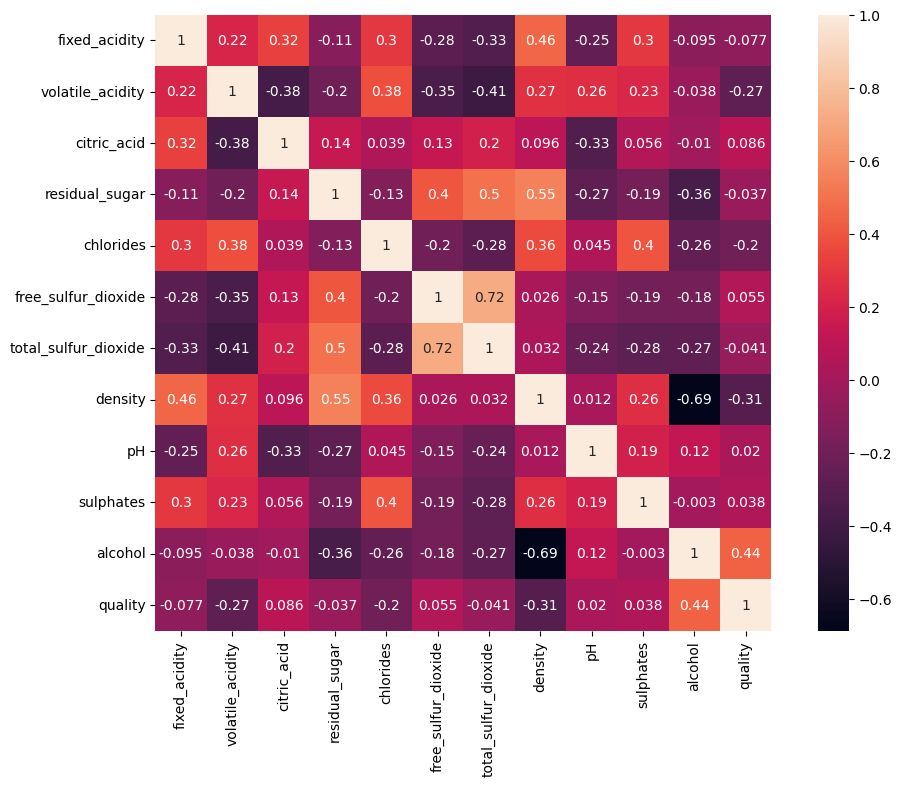

In [38]:
# Correlation matrix
plt.figure(figsize=(12, 8))
corrmat = df_wine.corr()
sns.heatmap(corrmat, square = True, annot=True)

Out from the plot, the strongest correlation can be observed between the attributes **`free_sulfur_dioxide`** and **`total_sulfur_dioxide`** (0.72). The reason for this is total sulfur dioxide includes the free sulfur dioxide, so the variable free sulfur will be removed from the dataset, as both variables represent almost the same information and this will reduce redundancy.

The second strongest correlation is between **`density`** and **`alcohol`** (-0.69). This correlation is negative, due to the fact that an increase in the alcohol graduation in wine leads to a loss of water quantity. Therefore, given that alcohol is less dense than water, the density of the wine decreases.

maybe test to remove density as it might be a constant value?

In [3]:
df_wine.drop(columns=['free_sulfur_dioxide'], inplace=True)
X.drop(columns=['free_sulfur_dioxide'], inplace=True)

/tmp/ipykernel_13707/1948943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['free_sulfur_dioxide'], inplace=True)


## Performance evaluation of regression models

We will put here the different model evaluations

### Simple Linear Regression

Simple linear regression assumes the dependency of Y on X (or $X_1$, $X_2$, ... , $X_n$) is linear. In simple linear regression, we have a single predictor X. Mathematically, we can write this linear relationship as: $Y = \beta_0 + \beta_1X + \epsilon$.

Let's plot again the pairplot with all the features and the target variable.

In [ ]:
sns.pairplot(df_wine, y_vars='quality',x_vars=df_wine.columns[:-1])
plt.show()

As we can see, a line cannot be drawn to represent the relationship between the features and the target variable. This is because the target variable is discrete. However, let's try to fit a simple linear regression model for each feature.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
plt.figure(figsize=(20, 15))
y = df_wine['quality']
for i, feature in enumerate(df_wine.columns[:-1]):
    plt.subplot(4, 3, i + 1)
    linear = LinearRegression()
    X = df_wine[[feature]]  # Reshape to 2D array
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    linear.fit(X_train, y_train)
    y_pred = linear.predict(X_test)
    plt.scatter(X_test, y_test)
    plt.plot(X_test, y_pred, color='red')
    plt.title(f"{feature} {r2_score(y_test, y_pred)}")
plt.tight_layout()
plt.show()

The results shows, what we expected. That a simple linear regression model cannot be used to predict the quality of the wine that is a discrete variable.

The highest $R^2$ score is 0.18, for the feature alcohol, which is very low. The rest are close to 0.

**Conclusion**: Can't use simple linear regression.

### Multilinear Regression

#### Multilinear Regression - Ridge criterion

The following block of code will make the preparations for a multilinear regression model using the Ridge criterion. The model will be trained and evaluated using the dataset. Firstly, the train-test division will be performed, then the model will be trained and evaluated following a cross validation factor of 5.

In [24]:
# Make the Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train data shape: ", X_train.shape, y_train.shape)

print("Test data shape: ", X_test.shape, y_test.shape)

# Create the Ridge Multilinear Regression model. We will

ridge_regressor = RidgeCV(cv=5)

# Fit the model
ridge_regressor.fit(X_train, y_train)

Train data shape:  (5197, 10) (5197, 1)
Test data shape:  (1300, 10) (1300, 1)


RidgeCV(cv=5)

The regression model has been successfully trained. Now, some metrics will be extracted from it:
As we can see, a line cannot be drawn to represent the relationship between the features and the target variable. This is because the target variable is discrete. However, let's try to fit a simple linear regression model for each feature.

In [25]:
# Best lambda (alpha) selected by cross-validation
best_lambda = ridge_regressor.alpha_
print(f"Best lambda selected by RidgeCV: {best_lambda}")

Best lambda selected by RidgeCV: 0.1


Finally, the model is tested on the test set and is evaluated by the following metrics:

- Mean Squares Error (MAE)
- R² score

In [26]:

# Predict on the training and testing sets
y_train_pred = ridge_regressor.predict(X_train)
y_test_pred = ridge_regressor.predict(X_test)

# Calculate both Mean Squared Error and R2 Score
train_mse_ridge = mean_squared_error(y_train, y_train_pred)
test_mse_ridge = mean_squared_error(y_test, y_test_pred)

train_r2_ridge = r2_score(y_train, y_train_pred)
test_r2_ridge = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse_ridge}")
print(f"Test MSE: {test_mse_ridge}")
print(f"Train R2: {train_r2_ridge}")
print(f"Test R2: {test_r2_ridge}")



Train MSE: 0.5473203971891101
Test MSE: 0.5447018446339885
Train R2: 0.28768055003622617
Test R2: 0.26246801856881863


**Conclusion:** The model has not a good performance, the MSE is high and the R² score is low. This means that the model is not able to accurately predict the quality of the wine based on the physicochemical properties. This may be due to the fact that the target variable is discrete and not continuous, so a classification approach may be more suitable for this problem.

#### Multilienar Regression - Lasso criterion

### Polynomial Regression

### Decision Tree Regression

### Random Forest Regressor

The Random Forest Regressor model is based on decorrelated trees that reduce the variance of the model and reduce overfitting. This is a powerful tool as our dataset is higly imbalance.

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.stats import randint

We will use the parameter `stratify` in the `train_test_split` function to ensure that the distribution of the target variable is the same in the training and testing sets.

In [ ]:
X = df_wine.drop(columns=['quality'])
X_train, X_test, y_train, y_test = train_test_split(X, df_wine['quality'], test_size=0.2, random_state=42, stratify=df_wine['quality'])

In [ ]:
rf = RandomForestRegressor(random_state=42)

We have decided to use the `RandomizedSearchCV` to find the best hyperparameters as the performance is more or less equal to the `GridSearchCV` but it is 10 times faster (in this case). The hyperparameters that will be tuned are:
* n_estimators: the number of trees in the forest.
* max_depth: the maximum depth of the tree.
* min_samples_split: the minimum number of samples required to split an internal node.
* min_samples_leaf: the minimum number of samples required to be at a leaf node.

In [ ]:
# Define the parameter distribution for Random Search
param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
                                n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)

random_search.fit(X_train, y_train)
y_pred_random = random_search.predict(X_test)

# Print statics
print("Best Parameters from Random Search:", random_search.best_params_)
print("Best Score from Random Search:", random_search.best_score_)
print("----Test set----")
print("MSE = ", mean_squared_error(y_test, y_pred_random))
print("R2 = ", r2_score(y_test, y_pred_random))
print("MAE = ", mean_absolute_error(y_test, y_pred_random))


After training the model, the resulting best hyperparameters are:
* n_estimators: 138
* min_samples_split: 2
* min_samples_leaf: 1
* max_depth: 20

About the **performance metrics**, the best model achieves the following results:
* MSE = 0.387 which is lower than the variance of the target variable, so the mode's error is lower than the dispersion of the target variable.
* $R^2$ = 0.492 means that the model explains almost half of the variance of the `quality` variable.
* MAE = 0.441 means the error between the predicted and the true value is 0.441

Most of the `quality` values are between 7 and 5, so the model is better at predicting these values. 

In [ ]:
print("Variance of the variable quality = ", df_wine['quality'].var())

In [ ]:
plot_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_random}, index=X_test.index)
plot_df.sort_index(inplace=True)

# Plotting the actual vs predicted values
plt.figure(figsize=(16, 8))
plt.plot(plot_df.index, plot_df['Actual'], label='Actual', color='lightblue', marker='o', markersize=4)
plt.plot(plot_df.index, plot_df['Predicted'], label='Predicted', color='salmon', marker='x', markersize=4)

plt.title('Actual vs Predicted Values for Random Forest Regressor')
plt.ylabel('Quality')
plt.legend()
plt.grid()


Now, let's check the importance of the features in the model to test if reducing the dimensionality of the dataset could improve the model.
This are the importance of the features in the random forest regressor model:

In [ ]:
print ('Feature Relevances')
print(pd.DataFrame({'Attributes': X_train.columns,
            'Feature importance':random_search.best_estimator_.feature_importances_}).sort_values('Feature importance', ascending=False))

In [ ]:
#Uncomment for retraining with a subset
# new_df = df_wine[['alcohol', 'volatile_acidity', 'residual_sugar', 'total_sulfur_dioxide', 'sulphates', 'pH']]
# X_train, X_test, y_train, y_test = train_test_split(new_df, df_wine['quality'], test_size=0.2, random_state=42, stratify=df_wine['quality'])

# rf = RandomForestRegressor(random_state=42)
# param_dist = {
#     'n_estimators': randint(50, 300),
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': randint(2, 11),
#     'min_samples_leaf': randint(1, 5)
# }
# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
#                                 n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)

# random_search.fit(X_train, y_train)
# y_pred_random_subset = random_search.predict(X_test)

# # Print statics
# print("Best Parameters from Random Search:", random_search.best_params_)
# print("Best Score from Random Search:", random_search.best_score_)
# print("----Test set----")
# print(f"MSE(subset) = {mean_squared_error(y_test, y_pred_random_subset):.3f} vs MSE(full) = {mean_squared_error(y_test, y_pred_random):.3f}")
# print(f"R2(subset) = {r2_score(y_test, y_pred_random_subset):.3f} vs R2(full) = {r2_score(y_test, y_pred_random):.3f}")
# print(f"MAE(subset) = {mean_absolute_error(y_test, y_pred_random_subset):.3f} vs MAE(full) = {mean_absolute_error(y_test, y_pred_random):.3f}")

The most important features is the `alcohol` whereas the least important is the `citric_acid`. Although training the model again with a subset of the features improves the time, it does not improve the performance of the model. Taking int account that the error should decrease and the $R^2$ should increase.

**Conclusion for Random Forest Regressor**: This might be a good model if we want to focus on the most common values of the quality (5, 6 and 7). However, the model is not able to predict the extreme values of the quality (3 and 9).


### Generative Additive Models (GAMs)

GAMs are derivations of a standard linear models which apply non-linear functions to predictors, all whilst mainting the additive structure of the model. They can be taken as an abstraction for a linear regression model.

Their formula can be written as: 

$y_i$ = $\beta_0$ + $\sum_{j=1}^p f_j(x_{ij}) + \epsilon_i $

As explained before, regression models are not suitable for this problem due to the discrete nature of the target variable. Nevertheless, let's try to fit a GAM model to the dataset.


In [14]:
from pygam import LinearGAM, s, l

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print("Train data shape: ", X_train.shape, y_train.shape)
print("Test data shape: ", X_test.shape, y_test.shape)
# Create the Generalized Additive Model
gam_regressor = LinearGAM(  l(0) +
                            s(1) +
                            l(2) +
                            s(3) +
                            l(4) +
                            s(5) +
                            l(6) +
                            s(7) +
                            l(8) +
                            s(9)
                        ).fit(X_train, y_train)



Train data shape:  (5197, 11) (5197, 1)
Test data shape:  (1300, 11) (1300, 1)


It's now time to make predictions on the test set and evaluate the model using the following metrics:

- Mean Squared Error (MSE)
- R² score

In [15]:
# Predict on the train and test set 
y_train_pred = gam_regressor.predict(X_train)
y_test_pred = gam_regressor.predict(X_test)

# Compare the results by using MSE and R2
train_mse_gam = mean_squared_error(y_train, y_train_pred)
print(f"Train MSE: {train_mse_gam}")

test_mse_gam = mean_squared_error(y_test, y_test_pred)
print(f"Test MSE: {test_mse_gam}")

train_r2_gam = r2_score(y_train, y_train_pred)
print(f"Train R2: {train_r2_gam}")

test_r2_gam = r2_score(y_test, y_test_pred)
print(f"Test R2: {test_r2_gam}")



Train MSE: 0.5215202183377288
Test MSE: 0.5747847376400991
Train R2: 0.32125863209340366
Test R2: 0.22173546753277873


The performance metrics do not look good at all. A graphical description of the performance is shown in the plots below:

<Figure size 640x480 with 0 Axes>

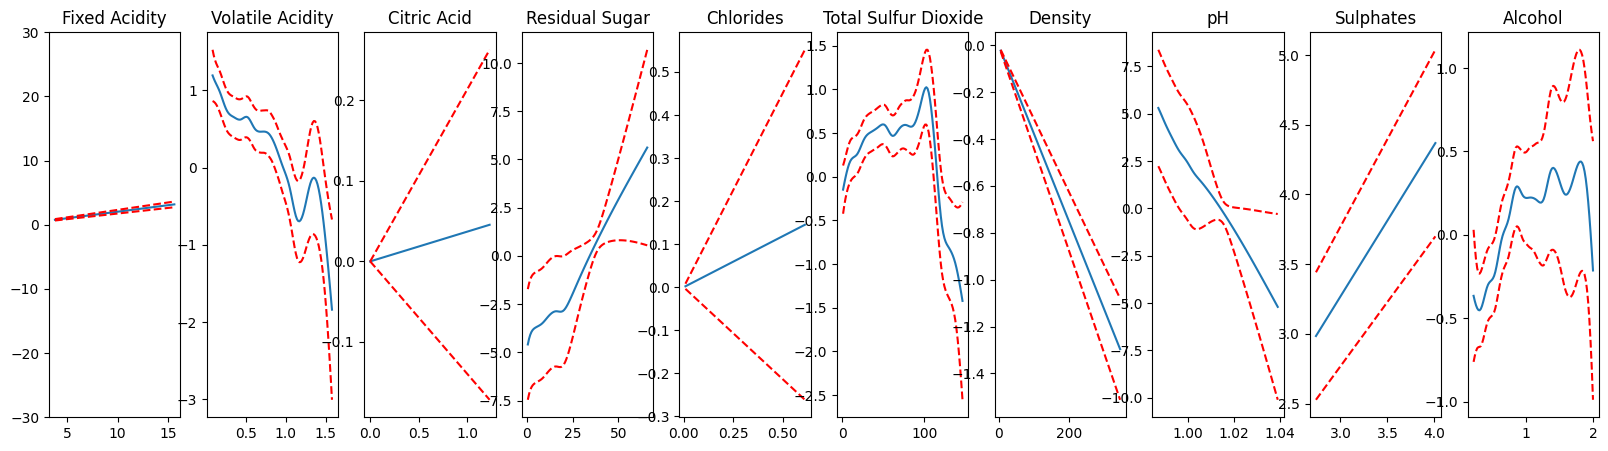

In [16]:
# Function plot
plt.figure()
fig, axs = plt.subplots(1, 10, figsize=(20, 5))

titles = ['Fixed Acidity', 'Volatile Acidity', 'Citric Acid', 'Residual Sugar', 'Chlorides', 'Total Sulfur Dioxide', 'Density', 'pH', 'Sulphates', 'Alcohol']
for i, ax in enumerate(axs):
    XX = gam_regressor.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam_regressor.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam_regressor.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

After the plots, a summary of the model's performance is shown.

In [17]:
gam_regressor.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     53.6341
Link Function:                     IdentityLink Log Likelihood:                                 -6326.5895
Number of Samples:                         5197 AIC:                                            12762.4472
                                                AICc:                                           12763.6295
                                                GCV:                                                0.5369
                                                Scale:                                               0.527
                                                Pseudo R-Squared:                                   0.3213
Feature Function                  Lam

/tmp/ipykernel_23712/642387991.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam_regressor.summary()


The P-Value is way too low, which means that the predictions of the model are very unreliable.

**Conclusion:** As expected, both MSE and R² score report very low performance, and so do the plots and the summary, which means that the model is not able to accurately predict the quality of the wine based on the physicochemical properties. This may be due to the fact that the target variable is discrete and not continuous, so a classification approach may be more suitable for this problem.

### Final decision

Here we mention the best model.

## Performance evaluation of classification models

We will put here the different model evaluations

### Naïve Bayes

#### Gaussian Naïve Bayes

#### Multinomial Naïve Bayes

### Decision Trees

#### Using Entropy as criterion

#### Using Gini Index as criterion

#### Using Knowledge Gain as criterion

### Random Forest Classifier

### KNN (K-Nearest Neighbors) "Lazy Learner"

### Final decision

Here we mention the best model.